# Neural Networks Coursework

## Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

## Dataset CIFAR - 10

In [5]:
# Data Loading and Preprocessing
def get_dataloaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    # Load datasets
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    # Create dataloaders with reduced memory usage
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, test_loader

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Basic Architecture

### Intermediate Block

In [7]:
# Define the Intermediate Block with Skip Connection
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels_list, kernel_sizes, strides=1, paddings=0):
        """
        Intermediate Block with parallel convolutional layers and skip connection
        
        Args:
            in_channels: Number of input channels
            out_channels_list: List of output channels for each conv layer
            kernel_sizes: List of kernel sizes for each conv layer
            strides: List of strides or single stride for all conv layers
            paddings: List of paddings or single padding for all conv layers
        """
        super().__init__()
        self.L = len(out_channels_list)  # Number of parallel conv layers
        
        # Convert to lists if single values are provided
        if isinstance(strides, int):
            strides = [strides] * self.L
        if isinstance(paddings, int):
            paddings = [paddings] * self.L
            
        # Create parallel convolutional layers
        self.conv_layers = nn.ModuleList()
        for out_channels, kernel_size, stride, padding in zip(out_channels_list, kernel_sizes, strides, paddings):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
            )
        
        # Skip connection setup
        self.skip_connection = None
        if in_channels != out_channels_list[0]:  # Only needed if channel dimensions change
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels_list[0], 1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels_list[0])
            )
        
        # Fully connected layer to compute combination weights 'a'
        self.fc = nn.Linear(in_channels, self.L)
        
    def forward(self, x):
        # Compute channel averages (m vector)
        m = torch.mean(x, dim=[2, 3])  # (batch_size, in_channels)
        
        # Compute combination weights (a vector)
        a = F.softmax(self.fc(m), dim=1)  # (batch_size, L)
        
        # Apply each conv layer to input
        conv_outputs = []
        for conv in self.conv_layers:
            conv_outputs.append(conv(x))  # Each is (batch_size, out_channels, H, W)
        
        # Stack and combine outputs
        stacked = torch.stack(conv_outputs, dim=1)  # (batch_size, L, out_channels, H, W)
        a = a.view(-1, self.L, 1, 1, 1)  # Reshape for broadcasting
        combined = (stacked * a).sum(dim=1)  # (batch_size, out_channels, H, W)
        
        # Add skip connection if needed
        if self.skip_connection is not None:
            skip = self.skip_connection(x)
        else:
            skip = x
        
        return F.relu(combined + skip)  # Skip connection with ReLU

### Output Block:

In [8]:
# Define the Output Block
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_dims=[], num_classes=10, dropout_rate=0.2):
        """
        Output Block with optional hidden layers and dropout
        
        Args:
            in_channels: Number of input channels
            hidden_dims: List of hidden layer dimensions
            num_classes: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Create sequential FC layers
        layers = []
        prev_dim = in_channels
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.fc_layers = nn.Sequential(*layers)
        
    def forward(self, x):
        # Compute channel averages (m vector)
        m = torch.mean(x, dim=[2, 3])  # (batch_size, in_channels)
        
        # Pass through FC layers
        return self.fc_layers(m)

### Complete Neural Network:

In [9]:
# Define the Complete Network
class CIFAR10Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initial convolution to expand channels
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Intermediate blocks with skip connections
        self.block1 = IntermediateBlock(
            in_channels=32,
            out_channels_list=[64, 64, 64],
            kernel_sizes=[3, 5, 7],
            paddings=[1, 2, 3]
        )
        
        self.block2 = IntermediateBlock(
            in_channels=64,
            out_channels_list=[128, 128, 128],
            kernel_sizes=[3, 5, 7],
            paddings=[1, 2, 3]
        )
        
        self.block3 = IntermediateBlock(
            in_channels=128,
            out_channels_list=[256, 256, 256],
            kernel_sizes=[3, 5, 7],
            paddings=[1, 2, 3]
        )
        
        # Output block with dropout
        self.output = OutputBlock(
            in_channels=256,
            hidden_dims=[512, 256],
            num_classes=10,
            dropout_rate=0.3
        )
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = F.max_pool2d(x, 2)  # 16x16
        
        x = self.block1(x)
        x = F.max_pool2d(x, 2)  # 8x8
        
        x = self.block2(x)
        x = F.max_pool2d(x, 2)  # 4x4
        
        x = self.block3(x)
        return self.output(x)

## Training and Testing

### Training Function:

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def train_and_plot(model, train_loader, test_loader, epochs, lr, weight_decay):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Initialize metric storage
    batch_losses = []  # Store all batch losses
    epoch_train_acc = []
    epoch_test_acc = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Store batch loss
            batch_loss = loss.item()
            batch_losses.append(batch_loss)
            running_loss += batch_loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{running_loss/len(batch_losses):.4f}",
                'acc': f"{100*correct/total:.2f}%"
            })
        
        # Calculate epoch metrics
        train_acc = 100 * correct / total
        test_acc = evaluate_model(model, test_loader)
        
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, " +
              f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
        
        scheduler.step()
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Generate final plots after training completes
    generate_final_plots(batch_losses, epoch_train_acc, epoch_test_acc)
    
    print(f"Training complete. Best test accuracy: {best_acc:.2f}%")
    return best_acc

def generate_final_plots(batch_losses, train_acc, test_acc):
    """Create and save the final plots"""
    plt.figure(figsize=(15, 5))
    
    # Batch Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(batch_losses, 'b-', alpha=0.5)
    plt.title('Training Batch Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Cross Entropy Loss')
    plt.grid(True, alpha=0.3)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, 'g-', label='Training Accuracy', marker='o')
    plt.plot(test_acc, 'r-', label='Testing Accuracy', marker='o')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

## Execution

Files already downloaded and verified
Files already downloaded and verified
CIFAR10Net(
  (initial_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): IntermediateBlock(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Epoch 1/40: 100%|██████████| 391/391 [00:11<00:00, 34.65it/s, loss=1.4009, acc=48.59%]


Epoch 1: Train Loss: 1.4009, Train Acc: 48.59%, Test Acc: 53.94%


Epoch 2/40: 100%|██████████| 391/391 [00:10<00:00, 37.75it/s, loss=0.5203, acc=62.73%]


Epoch 2: Train Loss: 1.0406, Train Acc: 62.73%, Test Acc: 60.53%


Epoch 3/40: 100%|██████████| 391/391 [00:10<00:00, 36.44it/s, loss=0.3015, acc=67.99%]


Epoch 3: Train Loss: 0.9045, Train Acc: 67.99%, Test Acc: 66.73%


Epoch 4/40: 100%|██████████| 391/391 [00:11<00:00, 34.57it/s, loss=0.2037, acc=71.54%]


Epoch 4: Train Loss: 0.8146, Train Acc: 71.54%, Test Acc: 67.02%


Epoch 5/40: 100%|██████████| 391/391 [00:10<00:00, 37.20it/s, loss=0.1489, acc=74.10%]


Epoch 5: Train Loss: 0.7447, Train Acc: 74.10%, Test Acc: 74.08%


Epoch 6/40: 100%|██████████| 391/391 [00:10<00:00, 35.57it/s, loss=0.1061, acc=77.97%]


Epoch 6: Train Loss: 0.6365, Train Acc: 77.97%, Test Acc: 72.63%


Epoch 7/40: 100%|██████████| 391/391 [00:10<00:00, 37.80it/s, loss=0.0863, acc=78.99%]


Epoch 7: Train Loss: 0.6039, Train Acc: 78.99%, Test Acc: 78.08%


Epoch 8/40: 100%|██████████| 391/391 [00:11<00:00, 34.67it/s, loss=0.0723, acc=80.11%]


Epoch 8: Train Loss: 0.5783, Train Acc: 80.11%, Test Acc: 76.95%


Epoch 9/40: 100%|██████████| 391/391 [00:11<00:00, 34.26it/s, loss=0.0608, acc=81.07%]


Epoch 9: Train Loss: 0.5468, Train Acc: 81.07%, Test Acc: 78.79%


Epoch 10/40: 100%|██████████| 391/391 [00:11<00:00, 34.14it/s, loss=0.0536, acc=81.47%]


Epoch 10: Train Loss: 0.5357, Train Acc: 81.47%, Test Acc: 80.28%


Epoch 11/40: 100%|██████████| 391/391 [00:10<00:00, 36.36it/s, loss=0.0431, acc=83.49%]


Epoch 11: Train Loss: 0.4745, Train Acc: 83.49%, Test Acc: 82.04%


Epoch 12/40: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s, loss=0.0377, acc=84.48%]


Epoch 12: Train Loss: 0.4523, Train Acc: 84.48%, Test Acc: 82.30%


Epoch 13/40: 100%|██████████| 391/391 [00:10<00:00, 36.58it/s, loss=0.0337, acc=84.85%]


Epoch 13: Train Loss: 0.4380, Train Acc: 84.85%, Test Acc: 83.05%


Epoch 14/40: 100%|██████████| 391/391 [00:11<00:00, 35.42it/s, loss=0.0302, acc=85.38%]


Epoch 14: Train Loss: 0.4223, Train Acc: 85.38%, Test Acc: 82.91%


Epoch 15/40: 100%|██████████| 391/391 [00:11<00:00, 34.29it/s, loss=0.0279, acc=85.57%]


Epoch 15: Train Loss: 0.4185, Train Acc: 85.57%, Test Acc: 83.50%


Epoch 16/40: 100%|██████████| 391/391 [00:10<00:00, 36.99it/s, loss=0.0236, acc=86.97%]


Epoch 16: Train Loss: 0.3772, Train Acc: 86.97%, Test Acc: 84.46%


Epoch 17/40: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s, loss=0.0217, acc=87.16%]


Epoch 17: Train Loss: 0.3691, Train Acc: 87.16%, Test Acc: 84.23%


Epoch 18/40: 100%|██████████| 391/391 [00:10<00:00, 37.04it/s, loss=0.0200, acc=87.71%]


Epoch 18: Train Loss: 0.3603, Train Acc: 87.71%, Test Acc: 83.70%


Epoch 19/40: 100%|██████████| 391/391 [00:11<00:00, 34.39it/s, loss=0.0185, acc=87.79%]


Epoch 19: Train Loss: 0.3513, Train Acc: 87.79%, Test Acc: 84.37%


Epoch 20/40: 100%|██████████| 391/391 [00:10<00:00, 37.17it/s, loss=0.0173, acc=88.06%]


Epoch 20: Train Loss: 0.3467, Train Acc: 88.06%, Test Acc: 84.25%


Epoch 21/40: 100%|██████████| 391/391 [00:10<00:00, 36.88it/s, loss=0.0156, acc=88.67%]


Epoch 21: Train Loss: 0.3266, Train Acc: 88.67%, Test Acc: 85.33%


Epoch 22/40: 100%|██████████| 391/391 [00:10<00:00, 36.03it/s, loss=0.0146, acc=88.93%]


Epoch 22: Train Loss: 0.3205, Train Acc: 88.93%, Test Acc: 85.44%


Epoch 23/40: 100%|██████████| 391/391 [00:10<00:00, 35.81it/s, loss=0.0139, acc=89.02%]


Epoch 23: Train Loss: 0.3188, Train Acc: 89.02%, Test Acc: 85.45%


Epoch 24/40: 100%|██████████| 391/391 [00:11<00:00, 35.46it/s, loss=0.0130, acc=89.11%]


Epoch 24: Train Loss: 0.3130, Train Acc: 89.11%, Test Acc: 85.32%


Epoch 25/40: 100%|██████████| 391/391 [00:10<00:00, 37.46it/s, loss=0.0122, acc=89.31%]


Epoch 25: Train Loss: 0.3060, Train Acc: 89.31%, Test Acc: 85.22%


Epoch 26/40: 100%|██████████| 391/391 [00:10<00:00, 35.73it/s, loss=0.0115, acc=89.62%]


Epoch 26: Train Loss: 0.2981, Train Acc: 89.62%, Test Acc: 85.66%


Epoch 27/40: 100%|██████████| 391/391 [00:10<00:00, 36.12it/s, loss=0.0110, acc=89.58%]


Epoch 27: Train Loss: 0.2964, Train Acc: 89.58%, Test Acc: 85.75%


Epoch 28/40: 100%|██████████| 391/391 [00:10<00:00, 36.91it/s, loss=0.0103, acc=89.92%]


Epoch 28: Train Loss: 0.2889, Train Acc: 89.92%, Test Acc: 85.70%


Epoch 29/40: 100%|██████████| 391/391 [00:09<00:00, 40.03it/s, loss=0.0099, acc=90.19%]


Epoch 29: Train Loss: 0.2879, Train Acc: 90.19%, Test Acc: 85.85%


Epoch 30/40: 100%|██████████| 391/391 [00:09<00:00, 42.98it/s, loss=0.0095, acc=90.18%]


Epoch 30: Train Loss: 0.2865, Train Acc: 90.18%, Test Acc: 85.80%


Epoch 31/40: 100%|██████████| 391/391 [00:09<00:00, 43.16it/s, loss=0.0091, acc=90.16%]


Epoch 31: Train Loss: 0.2836, Train Acc: 90.16%, Test Acc: 86.08%


Epoch 32/40: 100%|██████████| 391/391 [00:09<00:00, 40.81it/s, loss=0.0087, acc=90.37%]


Epoch 32: Train Loss: 0.2785, Train Acc: 90.37%, Test Acc: 86.09%


Epoch 33/40: 100%|██████████| 391/391 [00:09<00:00, 40.55it/s, loss=0.0085, acc=90.37%]


Epoch 33: Train Loss: 0.2796, Train Acc: 90.37%, Test Acc: 85.77%


Epoch 34/40: 100%|██████████| 391/391 [00:09<00:00, 40.31it/s, loss=0.0081, acc=90.42%]


Epoch 34: Train Loss: 0.2763, Train Acc: 90.42%, Test Acc: 85.96%


Epoch 35/40: 100%|██████████| 391/391 [00:09<00:00, 42.17it/s, loss=0.0079, acc=90.36%]


Epoch 35: Train Loss: 0.2773, Train Acc: 90.36%, Test Acc: 85.93%


Epoch 36/40: 100%|██████████| 391/391 [00:09<00:00, 40.83it/s, loss=0.0076, acc=90.58%]


Epoch 36: Train Loss: 0.2748, Train Acc: 90.58%, Test Acc: 86.02%


Epoch 37/40: 100%|██████████| 391/391 [00:09<00:00, 39.60it/s, loss=0.0074, acc=90.58%]


Epoch 37: Train Loss: 0.2737, Train Acc: 90.58%, Test Acc: 86.03%


Epoch 38/40: 100%|██████████| 391/391 [00:09<00:00, 42.87it/s, loss=0.0072, acc=90.65%]


Epoch 38: Train Loss: 0.2720, Train Acc: 90.65%, Test Acc: 85.88%


Epoch 39/40: 100%|██████████| 391/391 [00:09<00:00, 41.93it/s, loss=0.0069, acc=90.78%]


Epoch 39: Train Loss: 0.2693, Train Acc: 90.78%, Test Acc: 86.10%


Epoch 40/40: 100%|██████████| 391/391 [00:09<00:00, 40.22it/s, loss=0.0068, acc=90.50%]


Epoch 40: Train Loss: 0.2731, Train Acc: 90.50%, Test Acc: 86.01%
Training complete. Best test accuracy: 86.10%
Final Model Accuracy: 86.10%


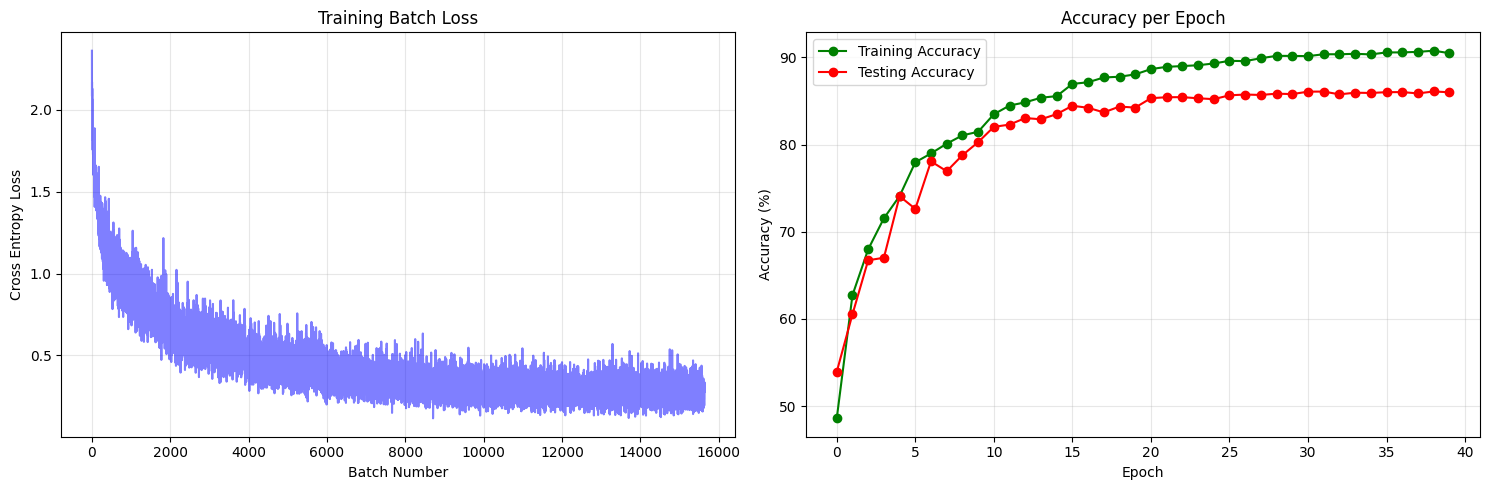

In [17]:
# Main execution
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 128
    epochs = 40
    learning_rate = 0.001
    weight_decay = 1e-4
    
    # Get data loaders
    train_loader, test_loader = get_dataloaders(batch_size)
    
    # Initialize model
    model = CIFAR10Net()
    print(model)
    
    # Train the model and generate final plots
    best_acc = train_and_plot(model, train_loader, test_loader, epochs, learning_rate, weight_decay)
    
    print(f"Final Model Accuracy: {best_acc:.2f}%")